Welcome to Lab 11 on using feed forward neural networks for brain machine interface decoding. You will complete this lab entirely in Python using the PyTorch library.

Start by including the following libraries below.

In [13]:
#Solutions code by Matt Mender, W-2021

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio #allows for importing of .mat files 
import numpy

from torch.utils.data import DataLoader, sampler, TensorDataset 
import torch.nn.functional as F

# If you are using colab, these commands may be helpful
#from google.colab import drive
#drive.mount("/content/drive")

# 1) Load Data with scipy and Pytorch

We will use the same dataset as previous labs, and we have written code for you to put this data into the right format for Pytorch tools. Please edit the file directory information to point to the 'contdata95.mat' file. If you are using Google Colab and have not previous loaded data, you can search online for how to mount a Google drive in Google Colab. 

Our first step is to load data from a matlab file using scipy and then transform it into a Tensor Dataset and Dataloader. A "Tensor" is Pytorch's array format, and has associated commands very similar to a Matlab array. See this link for a tutorial on Pytorch tensors. (https://www.youtube.com/watch?v=exaWOE8jvy8)

Here, we will generate the training and test data objects for you. A dataset simply combines the x and y data into one object that can be iterated together while a Dataloader adds a sampling method to the dataset.

The code below will load a mat file, concatenate features from the previous two time bins as additional lag features (for a total of 96x3 features), and then convert it to a PyTorch Dataloader. Change rootDir to be the folder holding the data you download, outDir, to be a folder where trained model parameters can live, and fn to be the file name of your downloaded mat file.

In [14]:
# Import your data here
rootDir = ''###Set this to the directory that has the contdata95 file
fn = 'contdata95.mat'


dtype = torch.float
conv_size = 3 # size of time history

# load the mat file
mat = sio.loadmat(rootDir+fn)

# Get each variable from the mat file
X = torch.tensor(mat['Y']) # This is switching Y in the mat file to X in our code - we programmed this with X as the neural data but contdata95.mat has Y as neural data.
y = torch.tensor(mat['X'])[:,0:4]

nsamp = X.shape[0]
ntrain = int(numpy.round(nsamp*0.8)) # using 80% of data for training

X_train = X[0:ntrain,:].to(dtype)
X_test = X[ntrain+1:,:].to(dtype)
y_train = y[0:ntrain,:].to(dtype)
y_test = y[ntrain+1:,:].to(dtype)


# Initialize tensor with conv_size*nfeatures features
X_ctrain = torch.zeros((int(X_train.shape[0]), int(X_train.shape[1]*conv_size)), dtype=dtype)
X_ctest = torch.zeros((int(X_test.shape[0]), int(X_test.shape[1]*conv_size)), dtype=dtype)
X_ctrain[:,0:X_train.shape[1]] = X_train
X_ctest[:,0:X_test.shape[1]] = X_test

# Add the previous 3 time bins features as a feature in the current time bin
for k1 in range(conv_size-1):
    k = k1+1
    X_ctrain[k:, int(X_train.shape[1]*k):int(X_train.shape[1]*(k+1))] = X_train[0:-k, :]
    X_ctest[k:, int(X_test.shape[1]*k):int(X_test.shape[1]*(k+1))] = X_test[0:-k, :]

# Create Dataset and dataloader
test_ds= TensorDataset(X_ctest, y_test)
train_ds = TensorDataset(X_ctrain, y_train)

#If a batch in BatchNorm only has 1 sample it wont work, so dropping the last in case that happens
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=True)

print('done')

done


# 2. Define your Network

We are going to build a small multi layer neural network, with one input layer, one hidden layer, and one output layer. To get a sense of the notation for initialization and specifying how data passes through the network, first read through the following short tutorial on setting up a Pytorch neural network. (https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html)

To define a network in Pytorch you need to define the layers of the neural network (or graph) within the init function and then define a forward function to evaluate how data passing through the network will be evaluated. Pytorch allows for quick network definitions where we essentially can plug and play with different layers and sizes (as long as the sizes match between connected layers). See https://pytorch.org/docs/stable/nn.html for documentation and syntax for the different kinds of layers that can be included.

Your inputs to the network defining function are already given below. The 'self' variable is your handle to this network itself. The 'input_size' is the number of units in the input layer. The 'hidden_size' is the number of units in the hidden layer. The 'num_states' is the number of units in the output layer, corresponding to your decode. 

The input and hidden layers should include batch normalization (nn.BatchNorm1d), a linear layer (nn.Linear), and dropout regularization with 50% dropout (nn.Dropout). The output layer should include batch normalization and a linear transform, but no dropout. After that, be sure to initalize your network using 'nn.init.kaiming_normal' with a 'relu' nonlinearity. The first one is done for you to show the syntax.

Your layers are now all defined, but you need to specify how everything connects and propagates through this network. Your data is given by 'x' in this function. Be sure to pass it through all of the layers you created in the correct order. (Note that batch normalization goes before the linear layer and dropout comes after.) Also include a '.relu' operation after each linear layer to implement the nonlinearity. 

The nn.init command (https://pytorch.org/docs/stable/nn.init.html)

Why we need batch normalization: (https://www.youtube.com/watch?v=DtEq44FTPM4)

Why we need dropout: (https://www.youtube.com/watch?v=ARq74QuavAo)

In [15]:
# input -> hidden -> output
class myNetwork(nn.Module):
    # input_size: 
    # hidden_size: 
    # num_states: 
    def __init__(self, input_size, hidden_size, num_states, init_=''):
        super().__init__()
        # Define the different layers

        #  Input layer
        self.bn_input = nn.BatchNorm1d(input_size) # batch normalize inputs to fc1
        self.ll_input = nn.Linear(input_size, hidden_size) # linear layer
        self.do_input = nn.Dropout(0.5)  # dropout layer

        #  Hidden layer
        self.bn_hidden = nn.BatchNorm1d(hidden_size) # batch normalize inputs to fc1
        self.ll_hidden = nn.Linear(hidden_size, hidden_size) # linear layer
        self.do_hidden = nn.Dropout(0.5)  # dropout layer
               
        #  Output layer
        self.bn_output = nn.BatchNorm1d(hidden_size) # batch normalize inputs to fc1
        self.ll_output = nn.Linear(hidden_size, num_states) # linear layer
        
        # Initialization
        if(init_ == 'uniform'):
            nn.init.kaiming_uniform(self.ll_input.weight, nonlinearity='relu')
            nn.init.kaiming_uniform(self.ll_hidden.weight, nonlinearity='relu')
            nn.init.kaiming_uniform(self.ll_output.weight, nonlinearity='relu')
        else:
            nn.init.kaiming_normal(self.ll_input.weight, nonlinearity='relu')
            nn.init.kaiming_normal(self.ll_hidden.weight, nonlinearity='relu')
            nn.init.kaiming_normal(self.ll_output.weight, nonlinearity='relu')

    # x  = data
    def forward(self, x):       

        # input layer
        x = self.bn_input(x)
        x = F.relu(self.ll_input(x))
        x = self.do_input(x)
        
        # hidden layer
        x = self.bn_hidden(x)
        x = F.relu(self.ll_hidden(x))
        x = self.do_hidden(x)
        
        # output layer
        x = self.bn_output(x)
        x = self.ll_output(x)
        
        ####Point this towards your output linear layer
        scores = x

        return scores

# 3. Train the network
To train the network we need to create an instance of the model, specify a loss function, and specify an optimizer to determine how the training implements gradient descent. For a humorous rious video explaining all of your optimizer options and how they differ, see here (https://www.youtube.com/watch?v=mdKjMPmcWjY). We will be using mean square error as our loss function and the ADAM optimizer. We have provided known good values for the weight_decay and the learning_rate, though in practice you'll need to experiment with this.

First, create a network with 285 input units, 256 hidden units, and 4 output units using the 'myNetwork' function. 

Then define your loss function using the '.mse_loss' option. You can read about how to define a loss functions at (https://pytorch.org/docs/stable/nn.functional.html) and about the options available, including MSE, at (https://pytorch.org/docs/master/nn.html#loss-functions).

Finally, create an optimizer object utilizaing the Adam optimizer. You can read about how to do this at (https://pytorch.org/docs/stable/optim.html).

In [16]:
# Specify a model, loss function, and optimizer
weight_decay = 1e-2
learning_rate = 1e-5

# create the network
input_size = 285
hidden_size = 256
output_size = 4

net_normal = myNetwork(input_size, hidden_size, output_size)
net_uniform = myNetwork(input_size, hidden_size, output_size, 'uniform')

#Define the loss function
loss_fn = nn.MSELoss() 

#Define the optimizer
opt_normal = torch.optim.Adam(net_normal.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt_uniform = torch.optim.Adam(net_uniform.parameters(), lr=learning_rate, weight_decay=weight_decay)



<ipython-input-15-1b9ff610a7a0>:26: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(self.ll_input.weight, nonlinearity='relu')
<ipython-input-15-1b9ff610a7a0>:27: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(self.ll_hidden.weight, nonlinearity='relu')
<ipython-input-15-1b9ff610a7a0>:28: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(self.ll_output.weight, nonlinearity='relu')


In order to train the network, we also need a function that will iterate through our dataset and use the optimizer to update parameters. We have set up the function for you. It's expecting the number of epochs, the network object itself, the loss function, the optimizer, training data and validation data. All of this you should already have. Most of the syntax you will need is listed at the top of the page describing optimizers.

The data loader class helps us so that we do not need to program in the sampling but we do need to specify how each batch updates the model weights. Remember - in general the batch size indicates how many samples are grabbed at the same time while the number of epochs will be the number of times we step through the entire dataset.

Below is the outline of a function to update weights. Fill in the blanks of the fit function so that it can train a network

In [17]:
def myfit(epochs, nntofit, loss_fn, opt, train_dl, val_dl, print_every=1):
    train_loss = torch.zeros(epochs * len(train_dl) , dtype=torch.float) # train error for every iteration
    validation_loss = torch.zeros(epochs , dtype=torch.float) # validation is only once per epoch
    i = -1 # iteration number
    for epoch in range(epochs):
        
        for x,y in train_dl: # batch of training points
            i += 1
            # Set model in train mode (for batch normalization and dropout)
            nntofit.train()
            
            # 1. Generate your predictions by running x through the network
            yh = nntofit(x)
        
            # 2. Find Loss by comparing predicted and actual using loss function
            loss = loss_fn(yh, y) #??second parameter
            
            # 3. Calculate gradients with respect to weights/biases 
            loss.backward()
            train_loss[i] = loss.item() #Keep track of loss on training data
        
            # 4. Adjust your weights by taking a step forward on the optimizer
            opt.step()
            
            # 5. Reset the gradients to zero on the optimizer
            opt.zero_grad()
            
        #Validation accuracy
        for xval,yval in val_dl:
            with torch.no_grad(): # disable gradient calculation
                nntofit.eval() # set model to evaluation mode (matters for batch normalization and dropout)
                loss2 = loss_fn(nntofit(xval),yval)
                validation_loss[epoch] = loss2.item()
    return train_loss, validation_loss



# 4. Evaluate the network
Now it's time to actually fit the network. Here you can specify a number of epochs to train over and then call the fit function. We have provided the code for you for the training step. This is the step that takes the longest to run. Note that you may want to try a small number of epochs while debugging.

In [18]:
# Train the network
n_epochs = 10
train_loss_normal, validation_loss_normal = myfit(n_epochs, net_normal, loss_fn, opt_normal, train_dl, test_dl)
train_loss_uniform, validation_loss_uniform = myfit(n_epochs, net_uniform, loss_fn, opt_uniform, train_dl, test_dl)

Now let's evaluate how well it's working. This code is also provided for you to measure training and validation losses. If the code above is correct, this will provide MSE across the iterations, which should be going down as the network trains. Note that train_loss has 1 loss per batch while validation_loss has 1 loss per epoch. Include this figure in your report. 

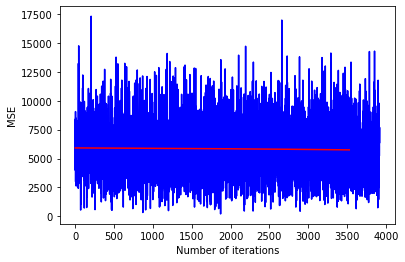

In [19]:
# Plot training and validation losses
plot_epochs = n_epochs

val_iters = numpy.arange(0,n_epochs)*len(train_dl)
train_iters = numpy.arange(0,len(train_dl)*n_epochs)
n_iter = len(train_dl) * n_epochs # number of batches per epoch * number of epochs 

plt.plot(train_iters[0:plot_epochs*len(train_dl)], train_loss_normal[0:plot_epochs*len(train_dl)], 'b')
plt.plot(val_iters[0:plot_epochs], validation_loss_normal[0:plot_epochs], 'r')
plt.title('Init = normal')
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.show()

plt.plot(train_iters[0:plot_epochs*len(train_dl)], train_loss_uniform[0:plot_epochs*len(train_dl)], 'b')
plt.plot(val_iters[0:plot_epochs], validation_loss_uniform[0:plot_epochs], 'r')
plt.title('Init = uniform')
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.show()

Here is some code to actually decode the positions and generate correlation values for your report. Include this figure in your report as well as the correlation values in a table.



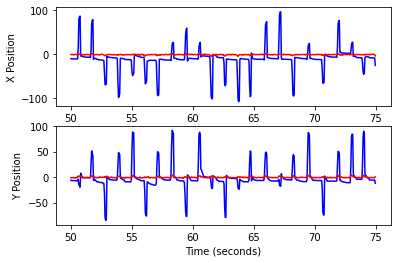

Correlation for X position is 0.57533
Correlation for Y position is 0.431667
Correlation for X velocity is 0.717307
Correlation for Y velocity is 0.59208
Average Correlation: 0.579096


In [20]:
# Plot some example decodes
for x,y in test_dl:
    with torch.no_grad():
        yh_normal = net_normal(x)
        yh_uniform = net_uniform(x)
        #looking at select channel
    th = numpy.arange(0, x.shape[0])*50e-3
    
    #normal
    plt.subplot(2,1,1)
    plt.plot(th[1000:1500], y[1000:1500,0],'b')
    plt.plot(th[1000:1500],yh_normal[1000:1500,0].detach().numpy(), 'r')
    plt.ylabel('X Position')
    
    plt.subplot(2,1,2)
    plt.plot(th[1000:1500], y[1000:1500,1], 'b')
    plt.plot(th[1000:1500],normal[1000:1500,1].detach().numpy(), 'r')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Y Position')
    
    plt.show()

    r = numpy.corrcoef(yh_normal.detach().numpy().T,y.T)
    r = numpy.diag(r[4:,0:4])
    print('Normal: Correlation for X position is %g' % r[0])
    print('Normal: Correlation for Y position is %g' % r[1])
    print('Normal: Correlation for X velocity is %g' % r[2])
    print('Normal: Correlation for Y velocity is %g' % r[3])
    print('Normal: Average Correlation: %g' % numpy.mean(r))

    # uniform
    plt.subplot(2,1,1)
    plt.plot(th[1000:1500], y[1000:1500,0],'b')
    plt.plot(th[1000:1500],yh_uniform[1000:1500,0].detach().numpy(), 'r')
    plt.ylabel('X Position')
    
    plt.subplot(2,1,2)
    plt.plot(th[1000:1500], y[1000:1500,1], 'b')
    plt.plot(th[1000:1500]yh_uniform[1000:1500,1].detach().numpy(), 'r')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Y Position')
    
    plt.show()
    
    r = numpy.corrcoef(yh_uniform.detach().numpy().T,y.T)
    r = numpy.diag(r[4:,0:4])
    print('Normal: Correlation for X position is %g' % r[0])
    print('Normal: Correlation for Y position is %g' % r[1])
    print('Normal: Correlation for X velocity is %g' % r[2])
    print('Normal: Correlation for Y velocity is %g' % r[3])
    print('Normal: Average Correlation: %g' % numpy.mean(r))


**One more thing to do before you're done!** Once you are happy with your network, go back and try it with a uniform initialization instead. Report the new correlations in your lab report as well. 